In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import imblearn

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('employee.csv')
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,1264,Finance,region_7,Bachelor's,m,other,1,31,3.0,3,0,0,62,0
1,18375,Finance,region_7,Bachelor's,m,other,1,31,5.0,7,1,0,62,0
2,34167,Operations,region_2,Bachelor's,m,other,1,53,3.0,22,0,0,67,0
3,14280,Technology,region_29,Bachelor's,m,other,1,27,2.0,2,1,0,81,0
4,24219,Sales & Marketing,region_26,Bachelor's,m,other,1,44,3.0,6,1,0,57,0


#### Data Cleansing

In [3]:
data.duplicated().any()

False

In [4]:
def check_missing(dataframe):
    df_miss = pd.DataFrame(dataframe.isnull().sum(),columns=['Count'])
    df_miss['percent']= round(dataframe.isnull().sum()/dataframe.shape[0]*100, 2)
    df_miss.reset_index(inplace=True)
    tipe = []
    for kolom in list(df_miss['index']):
        tipe.append(data[kolom].dtype)
    df_miss['TipeData'] = tipe
    return df_miss.loc[df_miss['Count']>0, :]

In [5]:
check_missing(data)

,index,Count,percent,TipeData
3,education,1429,4.35,object
8,previous_year_rating,2467,7.50,float64


In [6]:
data['education'].unique()

array(["Bachelor's", "Master's & above", nan, 'Below Secondary'],
      dtype=object)

In [7]:
data['education'] = data['education'].fillna(data['education'].mode()[0])

In [8]:
data['previous_year_rating'].unique()

array([ 3.,  5.,  2.,  4.,  1., nan])

In [9]:
data['previous_year_rating'] = data['previous_year_rating'].fillna(data['previous_year_rating'].mode()[0])

In [10]:
check_missing(data)

,index,Count,percent,TipeData


<AxesSubplot:>

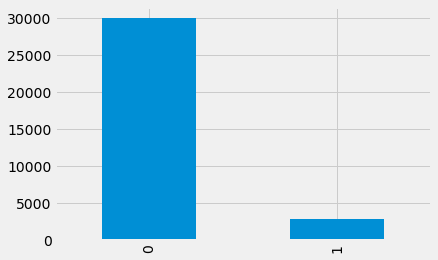

In [11]:
data['is_promoted'].value_counts().plot.bar()

### Data Preparation

In [12]:
obj_col = list(data.select_dtypes('object').columns)
for kolom in obj_col:
    print(kolom)
    print(data[kolom].unique())
    print(data[kolom].nunique())

department
['Finance' 'Operations' 'Technology' 'Sales & Marketing' 'Procurement'
 'Analytics' 'HR' 'R&D' 'Legal']
9
region
['region_7' 'region_2' 'region_29' 'region_26' 'region_15' 'region_34'
 'region_32' 'region_31' 'region_16' 'region_17' 'region_22' 'region_6'
 'region_11' 'region_14' 'region_27' 'region_13' 'region_9' 'region_12'
 'region_21' 'region_28' 'region_23' 'region_20' 'region_4' 'region_1'
 'region_24' 'region_25' 'region_19' 'region_3' 'region_18' 'region_8'
 'region_30' 'region_10' 'region_33' 'region_5']
34
education
["Bachelor's" "Master's & above" 'Below Secondary']
3
gender
['m' 'f']
2
recruitment_channel
['other' 'referred' 'sourcing']
3


Encode Data

In [13]:
ohe = ['department', 'region', 'recruitment_channel']

df = pd.get_dummies(data, columns=ohe)

df['education'] = df['education'].replace({"Bachelor's": 1, "Master's & above": 2, "Below Secondary": 0})

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

In [14]:
df.drop(columns=['employee_id'], inplace=True)

In [15]:
label = df['is_promoted']
df_corr = df.drop(columns=['is_promoted'])
df_corr['Label'] = label

Text(0.5, 1.0, 'Heatmap Correlation for is_Promoted')

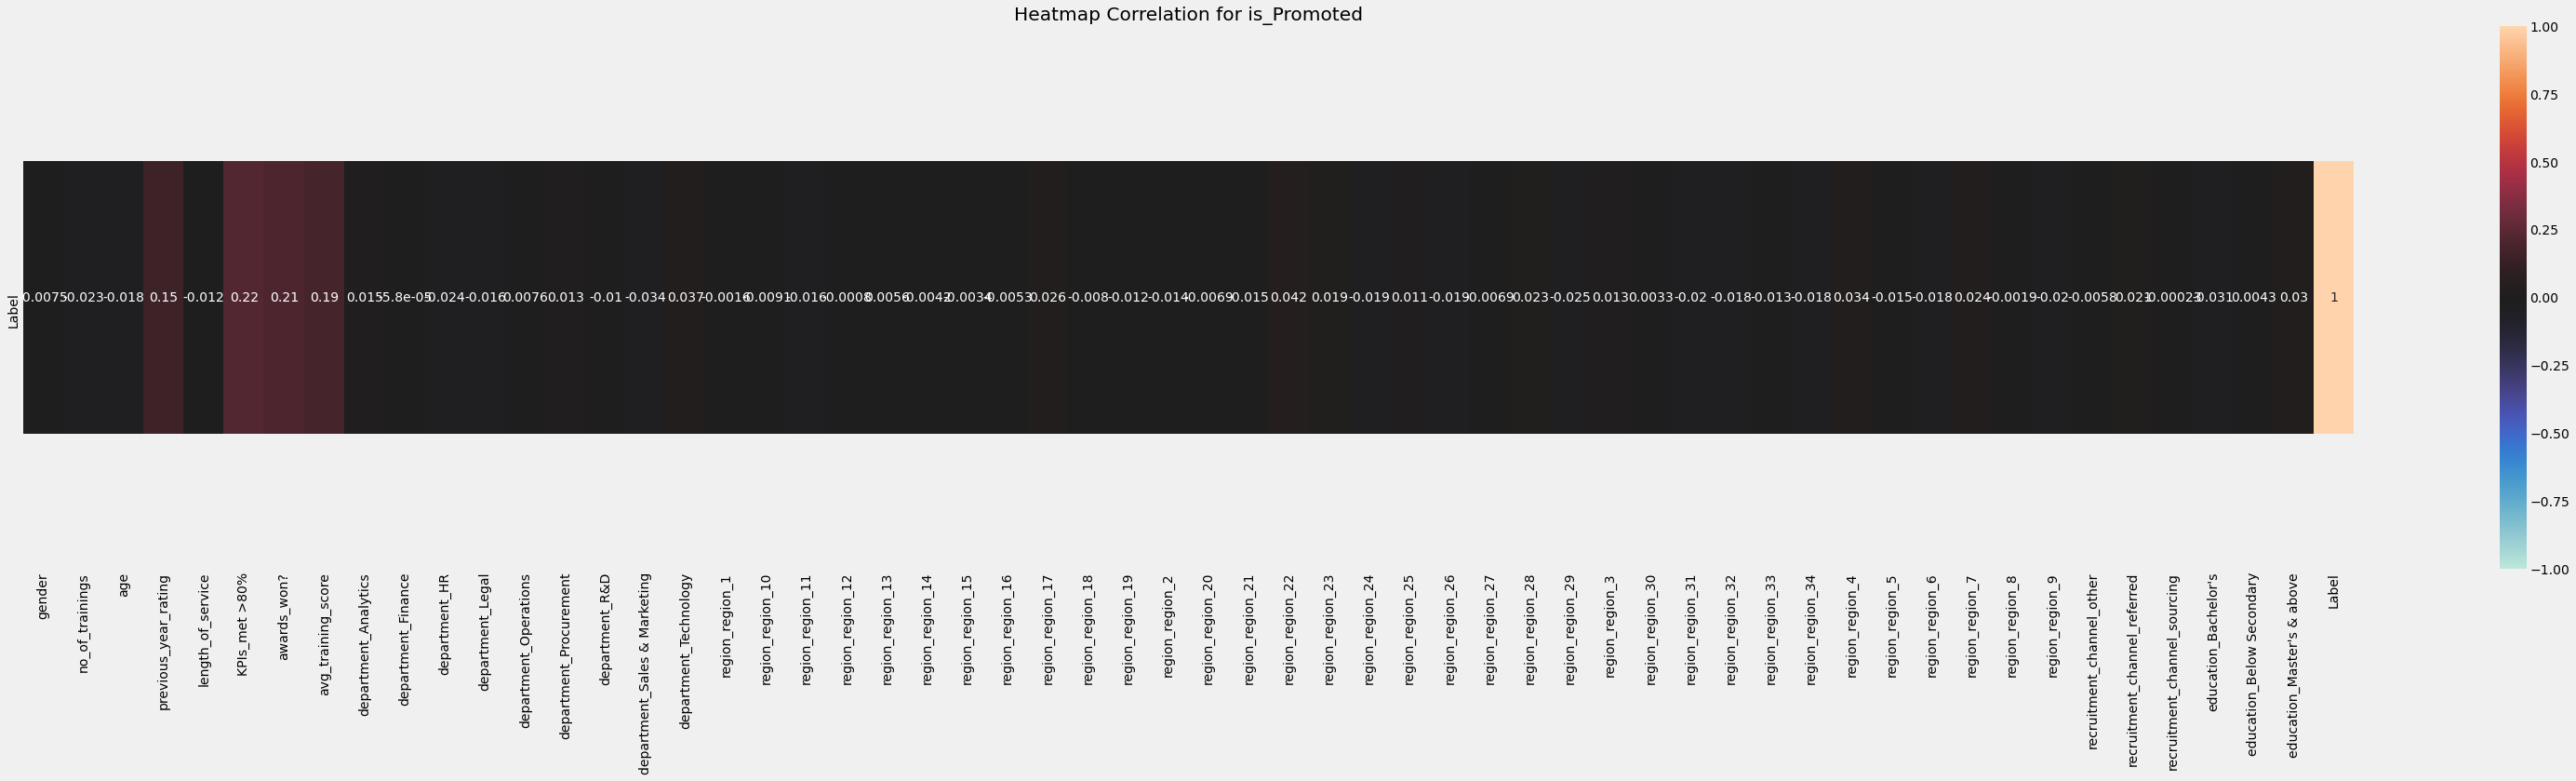

In [16]:
corr = df_corr.corr()
corr2 = corr.iloc[-1:,:]

plt.figure(figsize=(50, 10))
ax = sns.heatmap(corr2, annot=True, vmin=-1, vmax=1, center=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Heatmap Correlation for is_Promoted')

Feature yang memiliki korelasi lumayan tinggi terhadap target

- previous_year_rating
- KPIs_met >80%
- awards_won?
- avg_training_score

Split Data

In [17]:
from sklearn.model_selection import train_test_split

In [37]:
X = df.drop('is_promoted', axis=1)
y = df[['is_promoted']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Sampling

In [38]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [39]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()

X_under, y_under = undersample.fit_resample(X_train, y_train)

### Modeling

Base Model

In [21]:
from sklearn.ensemble import RandomForestClassifier

model_rf_smote = RandomForestClassifier()
model_rf_under = RandomForestClassifier()

model_rf_smote.fit(X_smote, y_smote)
model_rf_under.fit(X_under, y_under)

pred_rf_smote = model_rf_smote.predict(X_test)
pred_rf_under = model_rf_under.predict(X_test)

In [22]:
from sklearn.metrics import plot_confusion_matrix, classification_report

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5976
           1       0.54      0.29      0.38       601

    accuracy                           0.91      6577
   macro avg       0.74      0.63      0.67      6577
weighted avg       0.90      0.91      0.90      6577



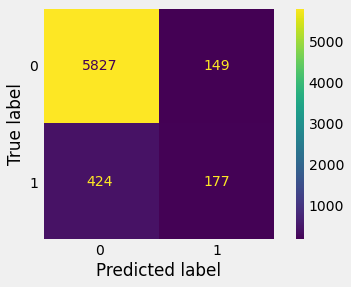

In [23]:
#smote
plot_confusion_matrix(model_rf_smote, X_test, y_test)
plt.grid(False)
print(classification_report(y_test, pred_rf_smote))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      5976
           1       0.25      0.85      0.39       601

    accuracy                           0.76      6577
   macro avg       0.62      0.80      0.62      6577
weighted avg       0.91      0.76      0.81      6577



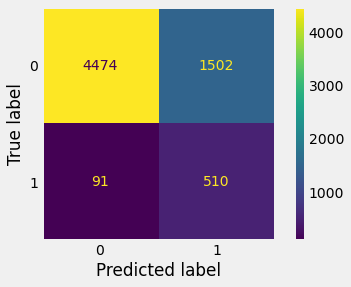

In [24]:
#under
plot_confusion_matrix(model_rf_under, X_test, y_test)
plt.grid(False)
print(classification_report(y_test, pred_rf_under))

In [25]:
fi_df = pd.DataFrame({
    'Feature' : list(X_smote.columns),
    'FI_smote' : model_rf_smote.feature_importances_,
    'FI_under' : model_rf_under.feature_importances_
})

In [26]:
#smote
fi_df.sort_values(by='FI_smote', ascending=False).head(10)

,Feature,FI_smote,FI_under
7,avg_training_score,0.173284,0.216635
3,previous_year_rating,0.140471,0.087021
5,KPIs_met >80%,0.074319,0.122895
2,age,0.069853,0.102782
4,length_of_service,0.055221,0.083097
53,recruitment_channel_sourcing,0.047170,0.015609
51,recruitment_channel_other,0.036406,0.015895
28,region_region_2,0.030888,0.014665
1,no_of_trainings,0.023977,0.023646
56,education_Master's & above,0.021743,0.009468


In [27]:
#under
fi_df.sort_values(by='FI_under', ascending=False).head(10)

,Feature,FI_smote,FI_under
7,avg_training_score,0.173284,0.216635
5,KPIs_met >80%,0.074319,0.122895
2,age,0.069853,0.102782
3,previous_year_rating,0.140471,0.087021
4,length_of_service,0.055221,0.083097
6,awards_won?,0.005260,0.030364
15,department_Sales & Marketing,0.017014,0.027016
1,no_of_trainings,0.023977,0.023646
0,gender,0.018344,0.021435
12,department_Operations,0.020716,0.016965


5 teratas keduanya dengan score yang cukup signifikan dibanding bawahnya adalah

- avg_training_score
- KPIs_met>80%
- age
- previous_year_rating
- length_of_service

Model Selection

In [28]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,1264,Finance,region_7,Bachelor's,m,other,1,31,3.0,3,0,0,62,0
1,18375,Finance,region_7,Bachelor's,m,other,1,31,5.0,7,1,0,62,0
2,34167,Operations,region_2,Bachelor's,m,other,1,53,3.0,22,0,0,67,0
3,14280,Technology,region_29,Bachelor's,m,other,1,27,2.0,2,1,0,81,0
4,24219,Sales & Marketing,region_26,Bachelor's,m,other,1,44,3.0,6,1,0,57,0


In [29]:
X_sel = df[['age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score']]
X_sel.head()

,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,31,3.0,3,0,0,62
1,31,5.0,7,1,0,62
2,53,3.0,22,0,0,67
3,27,2.0,2,1,0,81
4,44,3.0,6,1,0,57


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

Sampling

In [31]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [32]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler()

X_under, y_under = undersample.fit_resample(X_train, y_train)

### Modeling

In [33]:
from sklearn.ensemble import RandomForestClassifier

model_rf_smote = RandomForestClassifier()
model_rf_under = RandomForestClassifier()

model_rf_smote.fit(X_smote, y_smote)
model_rf_under.fit(X_under, y_under)

pred_rf_smote = model_rf_smote.predict(X_test)
pred_rf_under = model_rf_under.predict(X_test)

In [34]:
from sklearn.metrics import plot_confusion_matrix, classification_report

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      5976
           1       0.24      0.33      0.28       601

    accuracy                           0.84      6577
   macro avg       0.58      0.61      0.59      6577
weighted avg       0.87      0.84      0.85      6577



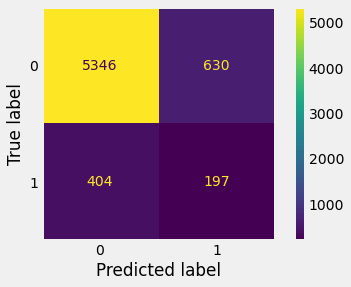

In [35]:
#smote
plot_confusion_matrix(model_rf_smote, X_test, y_test)
plt.grid(False)
print(classification_report(y_test, pred_rf_smote))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81      5976
           1       0.19      0.72      0.31       601

    accuracy                           0.70      6577
   macro avg       0.58      0.71      0.56      6577
weighted avg       0.89      0.70      0.76      6577



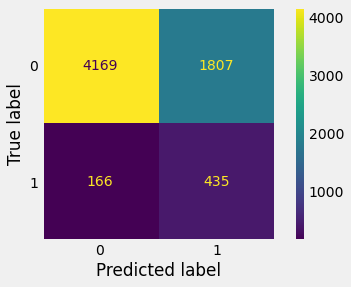

In [36]:
#under
plot_confusion_matrix(model_rf_under, X_test, y_test)
plt.grid(False)
print(classification_report(y_test, pred_rf_under))

### Model Selection and Hyperparameter Tuning

SMOTE

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
model_params = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy'],
            'min_samples_split': [1, 2, 3],
            'min_samples_leaf' : [1, 2, 3]
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [i for i in range(100,800,200)],
            'criterion' : ['gini', 'entropy'],
            'max_features' : ['auto', 'sqrt', 'log2'],
            'n_jobs' : [-1]
        }
    },
    'xgboost' : {
        'model': GradientBoostingClassifier(),
        'params': {
            'loss': ['deviance', 'exponential'],
            'learning_rate' : [0.1, 0.2],
            'n_estimators': [i for i in range(100,600,200)]
        }
    }
}

In [42]:
from sklearn.model_selection import GridSearchCV
from datetime import datetime
scores = []

start = datetime.now()

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_smote, y_smote)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
end = datetime.now()
print(end-start)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

0:23:21.279082


,model,best_score,best_params
0,DecisionTree,0.942329,"{'criterion': 'entropy', 'min_samples_leaf': 2..."
1,random_forest,0.955005,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
2,xgboost,0.948782,"{'learning_rate': 0.2, 'loss': 'deviance', 'n_..."


In [43]:
df[df['model']=='random_forest']['best_params']

1    {'criterion': 'gini', 'max_features': 'sqrt', ...
Name: best_params, dtype: object

In [45]:
scores[1]['best_params']

{'criterion': 'gini',
 'max_features': 'sqrt',
 'n_estimators': 300,
 'n_jobs': -1}

In [46]:
model = RandomForestClassifier(criterion='gini', max_features='sqrt', n_estimators=300, n_jobs=-1)

model.fit(X_smote, y_smote)

pred = model.predict(X_test)

In [47]:
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, roc_auc_score

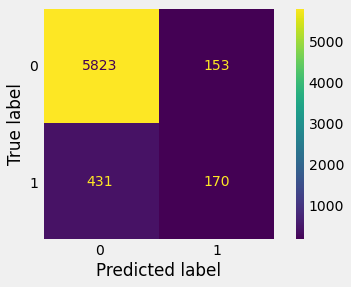

In [48]:
plot_confusion_matrix(model, X_test, y_test)
plt.grid(False)

In [49]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5976
           1       0.53      0.28      0.37       601

    accuracy                           0.91      6577
   macro avg       0.73      0.63      0.66      6577
weighted avg       0.89      0.91      0.90      6577



Under

In [50]:
from sklearn.model_selection import GridSearchCV
scores = []

start = datetime.now()
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_under, y_under)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
end = datetime.now()
print(end-start)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

0:02:34.302187


,model,best_score,best_params
0,DecisionTree,0.770913,"{'criterion': 'gini', 'min_samples_leaf': 1, '..."
1,random_forest,0.801355,"{'criterion': 'entropy', 'max_features': 'sqrt..."
2,xgboost,0.817783,"{'learning_rate': 0.2, 'loss': 'exponential', ..."


In [51]:
scores[2]['best_params']

{'learning_rate': 0.2, 'loss': 'exponential', 'n_estimators': 100}

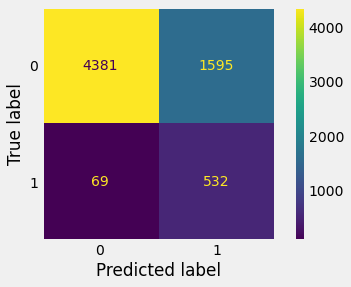

In [52]:
model = GradientBoostingClassifier(learning_rate=0.2, loss='exponential', n_estimators=100)

model.fit(X_under, y_under)

pred = model.predict(X_test)

plot_confusion_matrix(model, X_test, y_test)
plt.grid(False)

In [53]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      5976
           1       0.25      0.89      0.39       601

    accuracy                           0.75      6577
   macro avg       0.62      0.81      0.62      6577
weighted avg       0.92      0.75      0.80      6577

